In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from  sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from scipy import stats
import numpy as np
import pandas as pd
import pandas_gbq
import os

In [6]:
import seaborn as sns
from google.oauth2 import service_account

In [10]:
credentials = service_account.Credentials.from_service_account_file(
    '/Users/lap01227/Google_Drive/customer_segmentation/hannah/pipeline/credentials.json',)
sql = """
select prob_class1
from `tiki-dwh.consumer_product.cs_prediction_*`
"""
df = pandas_gbq.read_gbq(sql, project_id = 'tiki-dwh', credentials=credentials)

Downloading: 100%|██████████| 542589/542589 [00:21<00:00, 25339.82rows/s]


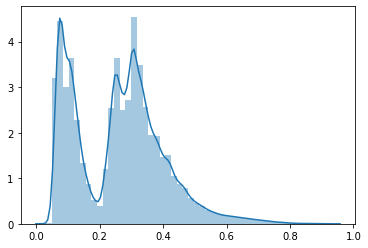

In [11]:
sns.distplot(df)

In [16]:
def get_data(file_name):
#     filename = os.path.join(os.getcwd(),'/',file_name)
    with open(file_name, 'r') as f:
        df = pd.read_csv(f) 
    return df

def split_data(dataset):
    X_train, X_test, y_train, y_test = train_test_split(
                                                            dataset.drop(columns=['user_label'])
                                                            , dataset['user_label']
                                                            , test_size=0.2
                                                            , random_state=99)
    return X_train, X_test, y_train, y_test

class ConvertCategorical(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self 

    def transform(self, X, y=None):
        # processed_df = X
        X['type_'] = LabelEncoder().fit_transform(X['type_'])

        for column in X.columns:
            if X[column].dtypes == 'object' and column not in ('deviceID', 'type_'):
                X[column] = X[column].astype(float)
        return X

class HandlingMissingValue(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self 

    def handling_missing_value(self, X, y=None):
        X.drop(columns=['reward', 'fixed_price', 'freegift', 'phieu_dat_coc_cate'], inplace=True)
        X.fillna(0, inplace=True)
        return X
    
    def transform(self, X, y=None):
        return self.handling_missing_value(X)

class HandlingOutliers(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self 

    def handling_outliers(self, X, y=None):
        num_col = X.columns[X.dtypes != 'object']
        outlier = pd.DataFrame()
        for col in num_col:
            outlier[col] = np.abs(stats.zscore(X[col]))

        X.drop(index=outlier[outlier.values > 3].index, inplace=True)
        X.set_index('deviceID', inplace=True)

        return X
    
    def transform(self, X, y=None):
        return self.handling_outliers(X)

class NewFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['TT_ratio'] = X['check_s'] / X['sum_cate']
        X.fillna(0, inplace=True)
        return X


process_pl = Pipeline(memory=None, steps=[
    ('convert_categorical', ConvertCategorical()),
    ('handling_missing_value', HandlingMissingValue()),
    ('handling_outliers', HandlingOutliers()),
    ('add_new_features', NewFeatures()),
    # ('split_data', SplitData),
], verbose=True)

In [17]:
raw = get_data('train.csv')
processing_data = process_pl.fit(raw)
X_train, X_test, y_train, y_test = split_data(raw)

[Pipeline]  (step 1 of 4) Processing convert_categorical, total=   0.2s
[Pipeline]  (step 2 of 4) Processing handling_missing_value, total=   0.5s
[Pipeline] . (step 3 of 4) Processing handling_outliers, total=   2.3s
[Pipeline] .. (step 4 of 4) Processing add_new_features, total=   0.0s


In [28]:
model = XGBClassifier(max_depth=9, n_estimators=100)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [29]:
print(model.score(X_test, y_test))
prediction = model.predict(X_train)
print(accuracy_score(y_train, prediction))

0.7386660311912516
0.7526345751582069


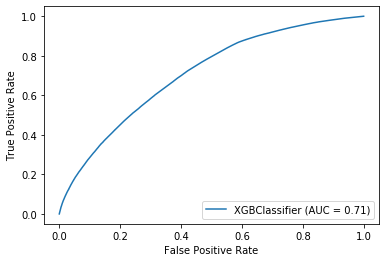

In [32]:
from sklearn import metrics
xgb_dis = metrics.plot_roc_curve(model, X_test, y_test)

In [42]:
raw_y_pred = model.predict_proba(X_test)
raw_y_pred = raw_y_pred[:, 1]
y_pred = []
for i in range(len(raw_y_pred)):
    if raw_y_pred[i] >= 0.2:
        y_pred.append(1)
    else: y_pred.append(0)  

In [43]:
y_test.value_counts()

0    137141
1     51694
Name: user_label, dtype: int64

In [45]:
print(accuracy_score(y_test, y_pred))

0.5337834617523235


[[55773 81368]
 [ 6670 45024]]


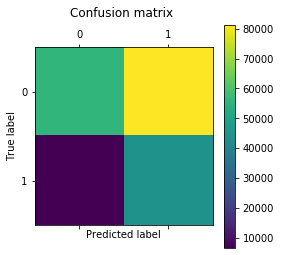

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
# from scikitplot import plot_confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion matrix \n')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [27]:
processing_data

Pipeline(memory=None,
         steps=[('convert_categorical', ConvertCategorical()),
                ('handling_missing_value', HandlingMissingValue()),
                ('handling_outliers', HandlingOutliers()),
                ('add_new_features', NewFeatures())],
         verbose=True)

In [28]:
raw.columns

Index(['no_of_screen', 'no_of_session', 'sum_atc', 'transportation_cate',
       'beauty_health_cate', 'home_living_cate', 'accessories_cate',
       'voucher_cate', 'electronic_cate', 'book_cate', 'phone_tablet_cate',
       'service_cate', 'lifestyle_cate', 'digital_device_cate', 'sport_cate',
       'cross_border_cate', 'laptop_cate', 'camera_cate', 'mom_baby_cate',
       'recycle_bin_cate', 'electric_appliances_cate', 'promotion_cate',
       'sum_cate', 'by_percent', 'cart_fixed', 'urban_area', 'sum_search',
       'check_s', 'seller', 'price_100000_2000000', 'price_0_50000',
       'price_200000_500000', 'price_50000_100000', 'price_500000_2000000',
       'price_2000000_5000000', 'price_bigger_5000000', 'sum_tikinow',
       'avg_review_verified', 'rating', 'type_', 'user_label'],
      dtype='object')